In [1]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import RidgeClassifier as LR
from sklearn.model_selection import cross_val_score
import seaborn as sns

sns.set_style("white")
sns.set_context("notebook")

In [21]:
def make_bxcar(l=200):
    l /= 2
    s = np.sin(np.linspace(0, np.pi, int(l)))
    b = np.ones(int(l) + 1)
    return minmax_scale(np.convolve(s, b))
def win_to_ts(t1, t2, ts=None):
    if ts is None:
        ts = np.random.randn(len(times)) * .033
    eff = make_bxcar(t2-t1)
    ts[t1:t2] += eff
    return ts
spatial_patterns = [
    np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1])]
n_features = len(spatial_patterns[0])
def make_trial(wins):
    p = np.random.randn(1000, n_features) #/ 5000
    for (t1, t2), pattern in zip(wins, spatial_patterns):
        eff = make_bxcar(t2-t1)
        p[t1:t2, :] += pattern * eff[:, np.newaxis]
    p -= p[:200, :].mean(0)[np.newaxis, :]
    return p

In [25]:
times = np.linspace(0, 1, 1000)
windows_processes = [[[250, 750]], ((300, 500), (500, 700)),
                     ((300, 574), (400, 700)), ((300, 500), (500, 700))]
heights_processes = [[[0.1, .3]], ((0, .175), (.2, .4)),
           ((0, .175), (.2, .4))]
names = ["Single Process", "Strictly Serial Sequence", "Cascading Sequence", "Latency Shift"]
colors = ((.3, .5, .6, 1), (.7, .1, .1, 1))
n_trials = 500

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


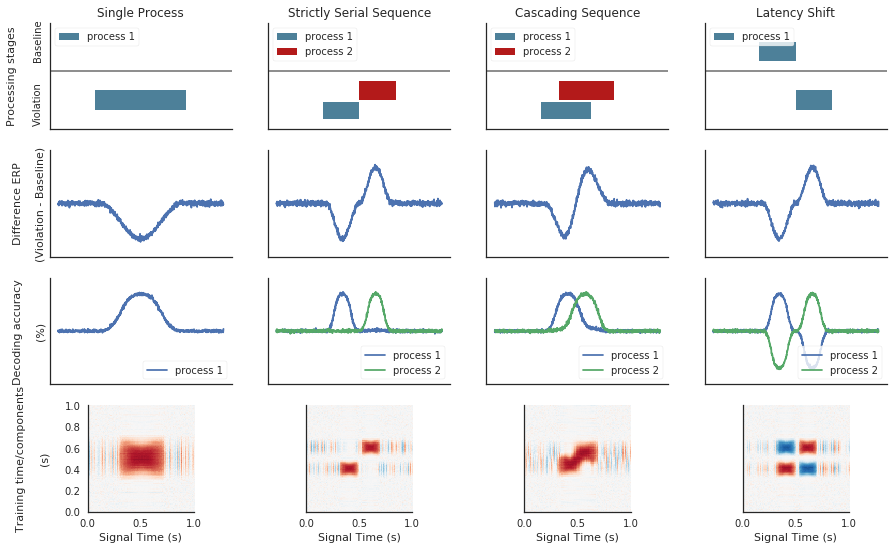

In [26]:

f, (axes_processes, axes_erp, axes_decoding, axes_gats) = plt.subplots(nrows=4, ncols=4)
f.set_size_inches((15, 9))
for ii, name in enumerate(names):
    ax_decoding, ax_erp, ax_gats, ax_boxes = (
        axes_decoding[ii], axes_erp[ii], axes_gats[ii], axes_processes[ii])
    wins = windows_processes[ii]
    if name == "Latency Shift":
        x1 = np.array([make_trial([wins[0]]) for _ in range(n_trials)])
        x2 = np.array([make_trial([wins[1]]) for _ in range(n_trials)])
        x3 = np.array([make_trial([wins[0]]) for _ in range(n_trials)])
        x4 = np.array([make_trial([wins[1]]) for _ in range(n_trials)])
    else:
        x1 = np.array([make_trial(wins) for _ in range(n_trials)])
        x2 = np.array([make_trial([]) for _ in range(n_trials)])
        x3 = np.array([make_trial(wins) for _ in range(n_trials)])
        x4 = np.array([make_trial([]) for _ in range(n_trials)])
    X = np.concatenate((x1, x2))
    X2 = np.concatenate((x3, x4))
    y = ([True] * n_trials) + ([False] * n_trials)
    ax_boxes.set_xlabel("")
    ax_boxes.set_xticks(())
    ax_boxes.set_ylim((-.1, 1))
    ax_boxes.axhline(.5, c='grey')
    if not ax_boxes.is_first_col():
        ax_boxes.set_ylabel("")
        ax_boxes.set_yticks(())
    else:
        ax_boxes.set_ylabel("Processing stages\n")
        ax_boxes.set_yticks((.35, 1.))
        ax_boxes.set_yticklabels(("Violation", "Baseline"), rotation=90)
    sns.despine()
    try:
        heights = heights_processes[ii]
        for ii, ((t1, t2), (h1, h2), color) in enumerate(zip(wins, heights, colors), 1):
            ax_boxes.axhspan(h1, h2, t1 / 1000, t2 / 1000,
                             facecolor=color, label='process ' + str(ii))
    except IndexError:
        ax_boxes.axhspan(.1, .3, .5, .7, facecolor=(.3, .5, .6, 1), label="process 1")
        ax_boxes.axhspan(.6, .8, .3, .5, facecolor=(.3, .5, .6, 1))
    ax_boxes.legend(frameon=True, loc=2)
    ax_boxes.set_title(name)
    ax_erp.plot(x2.mean(0).mean(-1) - x1.mean(0).mean(-1))
    ax_erp.set_ylim((-.5, .5))
    ax_erp.set_yticks(())
    ax_erp.set_xticks(())
    if ax_erp.is_first_col():
        ax_erp.set_ylabel("Difference ERP\n\n(Violation - Baseline)")
    for this_win, label in zip(wins,
                               ["process 1", "process 2"]):
        comp = int(np.mean(this_win))
        lda = LDA().fit(X[:, comp, :], y)
        scores = [lda.score(X[:, tp, :], y).mean() for tp in range(X.shape[1])]
        ax_decoding.plot(scores, label=label)
    ax_decoding.set_xticks(())
    ax_decoding.set_yticks(())
    ax_decoding.set_ylim((-.1, 1.1))
    ax_decoding.legend(frameon=True, loc="lower right")
    if ax_decoding.is_first_col():
        ax_decoding.set_ylabel("Decoding accuracy\n\n(%)")
    gat_scores = np.zeros((100, 100))
    for this_win in range(100):
        est = LR().fit(X[:, this_win * 10, :], y)
        
            
        gat_scores[this_win, :] = np.asarray([est.score(X2[:, tp * 10, :],
                                                        y).mean() for tp in range(100)])

    if ax_decoding.is_last_col():
        ax_gats.imshow(gat_scores.T, origin="lower", cmap="RdBu_r", vmax=1, vmin=0,
                   extent=(0, 1, 0, 1))
        
    else:
        ax_gats.imshow(gat_scores.T, origin="lower", cmap="RdBu_r", vmax=1, vmin=0,
                   extent=(0, 1, 0, 1))
 
    ax_gats.set_xlabel("Signal Time (s)")
    if ax_gats.is_first_col():
        ax_gats.set_ylabel("Training time/components\n\n(s)\n")
    else:
        ax_gats.set_yticks(())